In [1]:
from __future__ import print_function
import os
import mxnet as mx
import random
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
import scipy.misc
import gym
import math
from collections import namedtuple
import time


## Set the hyper parameters

In [2]:
class Options:
    def __init__(self):
        #Articheture
        self.batch_size = 32
        self.image_size = 80
        #Trickes
        self.replay_buffer_size = 1000000
        self.start_learning = 50000
        self.learning_frequency = 4
        self.skip_frame = 4
        self.frame_len = 4
        self.Target_update = 10000
        self.epsilon_min = 0.1
        self.annealing_end = 1000000.
        self.gamma = 0.99
        self.replay_start_size = 50000
        self.no_op_max = 30
        
        #otimization
        self.num_episode = 100000
        self.lr = 0.00025
        self.gamma1 = 0.95
        self.gamma2 = 0.95
        self.rms_eps = 0.01
        self.ctx = mx.gpu() #  enables gpu
opt = Options()
env_name = 'Assault-v0'
env = gym.make(env_name)
num_action = env.action_space.n

manualSeed = random.randint(1, 10000)
mx.random.seed(manualSeed)
attrs = vars(opt)
print (', '.join("%s: %s" % item for item in attrs.items()))

[2017-08-30 03:46:40,276] Making new env: Assault-v0
/EBS100G/RL/gym/gym/envs/registration.py:17: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


batch_size: 32, no_op_max: 30, lr: 0.00025, Target_update: 10000, num_episode: 1000, annealing_end: 100000.0, image_size: 80, skip_frame: 4, epsilon_min: 0.1, start_learning: 50000, termination_reward: -10.0, replay_start_size: 500, ctx: gpu(0), gamma1: 0.95, gamma: 0.99, frame_len: 4, gamma2: 0.95, replay_buffer_size: 1000000, learning_frequency: 4, rms_eps: 0.01


## Define the DQN network

In [3]:
DQN = gluon.nn.Sequential()
with DQN.name_scope():
    #first layer
    DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #second layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    DQN.add(gluon.nn.Flatten())
    #fourth layer
    DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    DQN.add(gluon.nn.Dense(num_action,activation ='relu'))

dqn = DQN
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
DQN_trainer = gluon.Trainer(dqn.collect_params(),'RMSProp', \
                          {'learning_rate': opt.lr ,'gamma1':opt.gamma1,'gamma2': opt.gamma2,'epsilon': opt.rms_eps,'centered' : True})
dqn.collect_params().zero_grad()


In [4]:
Target_DQN = gluon.nn.Sequential()
with Target_DQN.name_scope():
    #first layer
    Target_DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #second layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    Target_DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    Target_DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    Target_DQN.add(gluon.nn.Activation('relu'))
    Target_DQN.add(gluon.nn.Flatten())
    #fourth layer
    Target_DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    Target_DQN.add(gluon.nn.Dense(num_action,activation ='relu'))
target_dqn = Target_DQN
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)


## Class of replay buffer

In [5]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward','done'))
class Replay_Buffer():
    def __init__(self, replay_buffer_size):
        self.replay_buffer_size = replay_buffer_size
        self.memory = []
        self.position = 0
    def push(self, *args):
        if len(self.memory) < self.replay_buffer_size:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.replay_buffer_size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## Preprocess frames

In [6]:
def preprocess(raw_frame, currentState = None, initial_state = False):
    raw_frame = scipy.misc.imresize(raw_frame.mean(2), (opt.image_size,opt.image_size)).reshape([1,opt.image_size,opt.image_size]).astype(np.float32)/255.
    if initial_state == True:
        state = np.concatenate([raw_frame for _ in range(opt.frame_len)], axis =0)
    else:
        state = np.append(currentState[1:,:,:], raw_frame, axis = 0)
    return state
def rew_clipper(rew):
    if rew>0.:
        return 1.
    elif rew<0.:
        return -1.
    else:
        return 0
l2loss = gluon.loss.L2Loss(batch_axis=0)


## Initialize arrays

In [7]:
render_image = False
frame_counter = 0.
annealing_count = 0.
epis_count = 0.
replay_memory = Replay_Buffer(opt.replay_buffer_size)
value = nd.zeros(opt.batch_size,opt.ctx)
tot_clipped_reward = np.zeros(opt.num_episode)
tot_reward = np.zeros(opt.num_episode)
moving_average_clipped = 0.
moving_average = 0.

## Train the DQN 

In [8]:
for i in range(opt.num_episode):
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state = preprocess(next_frame, initial_state = True)
    t = 0.
    done = False
    while not done:
        previous_state = state
        # show the frame
        if render_image:
            plt.imshow(next_frame);
            plt.show()
            display.clear_output(wait=True)
            time.sleep(.01)
        sample = random.random()
        if frame_counter > opt.replay_start_size:
            annealing_count += 1
        if frame_counter == opt.replay_start_size:
            print('annealing and laerning are started ')
            
            
        
        eps = np.maximum(1.-annealing_count/opt.annealing_end,opt.epsilon_min)
        effective_eps = eps
        if t < opt.no_op_max:
            effective_eps = 1.
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = nd.array(state.reshape([1,opt.frame_len,opt.image_size,opt.image_size]),opt.ctx)
            action = int(nd.argmax(dqn(data),axis=1).as_in_context(mx.cpu()).asscalar())
        #skip frame
        rew = 0
        for skip in range(opt.skip_frame-1):
            next_frame, reward, done,_ = env.step(action)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
                
        next_frame_new, reward, done, _ = env.step(action)
        cum_clipped_reward += rew_clipper(reward)
        rew += reward
        cum_reward += rew
        #reward clipping
        reward = rew_clipper(rew)
        next_frame = np.maximum(next_frame_new,next_frame)
        state = preprocess(next_frame, state)
        replay_memory.push(previous_state,action,state,reward,done)
        
        if frame_counter > opt.replay_start_size:        
            if frame_counter % opt.learning_frequency == 0:
                transitions = replay_memory.sample(opt.batch_size)
                batch = Transition(*zip(*transitions))
                batch_state = nd.array(batch.state,opt.ctx)
                batch_state_next = nd.array(batch.next_state,opt.ctx)
                batch_reward = nd.array(batch.reward,opt.ctx)
                batch_action = nd.array(batch.action,opt.ctx).astype('int32')
                batch_done = nd.array(batch.done,opt.ctx)#.astype('int32')
                with autograd.record():
                    Q_sp = nd.max(target_dqn(batch_state_next),axis = 1)
                    Q_sp = Q_sp*(nd.ones(opt.batch_size,ctx = opt.ctx)-batch_done)
                    Q_s_array = dqn(batch_state)
                    Q_s = nd.pick(Q_s_array,batch_action,1)
                    #loss = nd.mean(nd.square(Q_s - (batch_reward +opt.gamma * Q_sp)))
                    loss = nd.mean(l2loss(Q_s ,  (batch_reward + opt.gamma *Q_sp)))
                loss.backward()
                DQN_trainer.step(opt.batch_size)
                
        


        t += 1
        frame_counter += 1
        if frame_counter > opt.replay_start_size:
            if frame_counter % opt.Target_update == 0 :
                check_point = frame_counter / (opt.Target_update *100)
                fdqn = './saved_dqn/target_%s_%d' % (env_name,int(check_point))
                dqn.save_params(fdqn)
                target_dqn.load_params(fdqn, opt.ctx)
        if done:
            print('epis[%d],eps[%f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %d,tot_cl = %d , tot = %d'\
                  %(epis_count,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward[int(epis_count)] = cum_clipped_reward
    tot_reward[int(epis_count)] = cum_reward
    if epis_count > 50.:
#         moving_average_clipped = (epis_count * moving_average_clipped + cum_clipped_reward)/(epis_count+1.)
#         moving_average = (epis_count * moving_average + cum_reward)/(epis_count+1.)
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-50:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-50:int(epis_count)-1])
    
    
    

epis[0],eps[1.000000],durat[228],fnum=227, cum_cl_rew = 4, cum_rew = 84,tot_cl = 0 , tot = 0
epis[1],eps[1.000000],durat[236],fnum=462, cum_cl_rew = 9, cum_rew = 189,tot_cl = 0 , tot = 0
annealing and laerning are started 
epis[2],eps[0.996710],durat[369],fnum=830, cum_cl_rew = 12, cum_rew = 252,tot_cl = 0 , tot = 0
epis[3],eps[0.993210],durat[351],fnum=1180, cum_cl_rew = 14, cum_rew = 294,tot_cl = 0 , tot = 0
epis[4],eps[0.991560],durat[166],fnum=1345, cum_cl_rew = 6, cum_rew = 126,tot_cl = 0 , tot = 0
epis[5],eps[0.989380],durat[219],fnum=1563, cum_cl_rew = 7, cum_rew = 147,tot_cl = 0 , tot = 0
epis[6],eps[0.986810],durat[258],fnum=1820, cum_cl_rew = 12, cum_rew = 252,tot_cl = 0 , tot = 0
epis[7],eps[0.984150],durat[267],fnum=2086, cum_cl_rew = 8, cum_rew = 168,tot_cl = 0 , tot = 0
epis[8],eps[0.981560],durat[260],fnum=2345, cum_cl_rew = 9, cum_rew = 189,tot_cl = 0 , tot = 0
epis[9],eps[0.979790],durat[178],fnum=2522, cum_cl_rew = 10, cum_rew = 210,tot_cl = 0 , tot = 0
epis[10],eps[0

epis[84],eps[0.770940],durat[253],fnum=23407, cum_cl_rew = 6, cum_rew = 126,tot_cl = 9 , tot = 197
epis[85],eps[0.769390],durat[156],fnum=23562, cum_cl_rew = 9, cum_rew = 189,tot_cl = 9 , tot = 198
epis[86],eps[0.767470],durat[193],fnum=23754, cum_cl_rew = 9, cum_rew = 189,tot_cl = 9 , tot = 197
epis[87],eps[0.764020],durat[346],fnum=24099, cum_cl_rew = 9, cum_rew = 189,tot_cl = 9 , tot = 195
epis[88],eps[0.761290],durat[274],fnum=24372, cum_cl_rew = 11, cum_rew = 231,tot_cl = 9 , tot = 194
epis[89],eps[0.759460],durat[184],fnum=24555, cum_cl_rew = 11, cum_rew = 231,tot_cl = 9 , tot = 194
epis[90],eps[0.757140],durat[233],fnum=24787, cum_cl_rew = 8, cum_rew = 168,tot_cl = 9 , tot = 194
epis[91],eps[0.752800],durat[435],fnum=25221, cum_cl_rew = 17, cum_rew = 357,tot_cl = 9 , tot = 194
epis[92],eps[0.749330],durat[348],fnum=25568, cum_cl_rew = 10, cum_rew = 210,tot_cl = 9 , tot = 195
epis[93],eps[0.746970],durat[237],fnum=25804, cum_cl_rew = 9, cum_rew = 189,tot_cl = 9 , tot = 197
epis[9

epis[166],eps[0.539710],durat[299],fnum=46530, cum_cl_rew = 13, cum_rew = 273,tot_cl = 9 , tot = 193
epis[167],eps[0.537040],durat[268],fnum=46797, cum_cl_rew = 11, cum_rew = 231,tot_cl = 9 , tot = 191
epis[168],eps[0.535700],durat[135],fnum=46931, cum_cl_rew = 6, cum_rew = 126,tot_cl = 9 , tot = 198
epis[169],eps[0.531370],durat[434],fnum=47364, cum_cl_rew = 10, cum_rew = 210,tot_cl = 9 , tot = 199
epis[170],eps[0.528160],durat[322],fnum=47685, cum_cl_rew = 13, cum_rew = 273,tot_cl = 9 , tot = 198
epis[171],eps[0.526000],durat[217],fnum=47901, cum_cl_rew = 6, cum_rew = 126,tot_cl = 9 , tot = 196
epis[172],eps[0.523530],durat[248],fnum=48148, cum_cl_rew = 7, cum_rew = 147,tot_cl = 9 , tot = 196
epis[173],eps[0.519540],durat[400],fnum=48547, cum_cl_rew = 14, cum_rew = 294,tot_cl = 9 , tot = 197
epis[174],eps[0.517170],durat[238],fnum=48784, cum_cl_rew = 8, cum_rew = 168,tot_cl = 9 , tot = 196
epis[175],eps[0.514570],durat[261],fnum=49044, cum_cl_rew = 11, cum_rew = 231,tot_cl = 9 , tot 

epis[247],eps[0.299470],durat[274],fnum=70554, cum_cl_rew = 14, cum_rew = 294,tot_cl = 10 , tot = 226
epis[248],eps[0.297220],durat[226],fnum=70779, cum_cl_rew = 9, cum_rew = 189,tot_cl = 10 , tot = 225
epis[249],eps[0.294550],durat[268],fnum=71046, cum_cl_rew = 12, cum_rew = 252,tot_cl = 10 , tot = 222
epis[250],eps[0.291850],durat[271],fnum=71316, cum_cl_rew = 9, cum_rew = 189,tot_cl = 10 , tot = 221
epis[251],eps[0.288830],durat[303],fnum=71618, cum_cl_rew = 9, cum_rew = 189,tot_cl = 10 , tot = 222
epis[252],eps[0.286490],durat[235],fnum=71852, cum_cl_rew = 13, cum_rew = 273,tot_cl = 10 , tot = 223
epis[253],eps[0.283550],durat[295],fnum=72146, cum_cl_rew = 18, cum_rew = 378,tot_cl = 10 , tot = 222
epis[254],eps[0.281210],durat[235],fnum=72380, cum_cl_rew = 14, cum_rew = 294,tot_cl = 10 , tot = 219
epis[255],eps[0.277890],durat[333],fnum=72712, cum_cl_rew = 15, cum_rew = 315,tot_cl = 10 , tot = 222
epis[256],eps[0.275790],durat[211],fnum=72922, cum_cl_rew = 9, cum_rew = 189,tot_cl =

epis[328],eps[0.100000],durat[265],fnum=92732, cum_cl_rew = 7, cum_rew = 147,tot_cl = 12 , tot = 259
epis[329],eps[0.100000],durat[254],fnum=92985, cum_cl_rew = 10, cum_rew = 210,tot_cl = 12 , tot = 258
epis[330],eps[0.100000],durat[212],fnum=93196, cum_cl_rew = 13, cum_rew = 273,tot_cl = 12 , tot = 262
epis[331],eps[0.100000],durat[385],fnum=93580, cum_cl_rew = 14, cum_rew = 294,tot_cl = 12 , tot = 261
epis[332],eps[0.100000],durat[98],fnum=93677, cum_cl_rew = 4, cum_rew = 84,tot_cl = 12 , tot = 262
epis[333],eps[0.100000],durat[247],fnum=93923, cum_cl_rew = 11, cum_rew = 231,tot_cl = 12 , tot = 263
epis[334],eps[0.100000],durat[349],fnum=94271, cum_cl_rew = 17, cum_rew = 357,tot_cl = 12 , tot = 264
epis[335],eps[0.100000],durat[316],fnum=94586, cum_cl_rew = 11, cum_rew = 231,tot_cl = 12 , tot = 260
epis[336],eps[0.100000],durat[287],fnum=94872, cum_cl_rew = 9, cum_rew = 189,tot_cl = 12 , tot = 257
epis[337],eps[0.100000],durat[299],fnum=95170, cum_cl_rew = 14, cum_rew = 294,tot_cl = 

epis[408],eps[0.100000],durat[236],fnum=112916, cum_cl_rew = 12, cum_rew = 252,tot_cl = 13 , tot = 288
epis[409],eps[0.100000],durat[185],fnum=113100, cum_cl_rew = 11, cum_rew = 231,tot_cl = 13 , tot = 285
epis[410],eps[0.100000],durat[196],fnum=113295, cum_cl_rew = 14, cum_rew = 294,tot_cl = 13 , tot = 280
epis[411],eps[0.100000],durat[175],fnum=113469, cum_cl_rew = 9, cum_rew = 189,tot_cl = 13 , tot = 279
epis[412],eps[0.100000],durat[277],fnum=113745, cum_cl_rew = 18, cum_rew = 378,tot_cl = 13 , tot = 276
epis[413],eps[0.100000],durat[255],fnum=113999, cum_cl_rew = 15, cum_rew = 315,tot_cl = 13 , tot = 277
epis[414],eps[0.100000],durat[231],fnum=114229, cum_cl_rew = 19, cum_rew = 399,tot_cl = 13 , tot = 279
epis[415],eps[0.100000],durat[264],fnum=114492, cum_cl_rew = 15, cum_rew = 315,tot_cl = 13 , tot = 280
epis[416],eps[0.100000],durat[183],fnum=114674, cum_cl_rew = 12, cum_rew = 252,tot_cl = 13 , tot = 282
epis[417],eps[0.100000],durat[293],fnum=114966, cum_cl_rew = 16, cum_rew =

epis[488],eps[0.100000],durat[187],fnum=132048, cum_cl_rew = 9, cum_rew = 189,tot_cl = 15 , tot = 318
epis[489],eps[0.100000],durat[302],fnum=132349, cum_cl_rew = 19, cum_rew = 399,tot_cl = 15 , tot = 320
epis[490],eps[0.100000],durat[185],fnum=132533, cum_cl_rew = 12, cum_rew = 252,tot_cl = 15 , tot = 321
epis[491],eps[0.100000],durat[304],fnum=132836, cum_cl_rew = 21, cum_rew = 441,tot_cl = 15 , tot = 319
epis[492],eps[0.100000],durat[196],fnum=133031, cum_cl_rew = 13, cum_rew = 273,tot_cl = 15 , tot = 319
epis[493],eps[0.100000],durat[255],fnum=133285, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 319
epis[494],eps[0.100000],durat[143],fnum=133427, cum_cl_rew = 9, cum_rew = 189,tot_cl = 15 , tot = 324
epis[495],eps[0.100000],durat[214],fnum=133640, cum_cl_rew = 16, cum_rew = 336,tot_cl = 15 , tot = 322
epis[496],eps[0.100000],durat[288],fnum=133927, cum_cl_rew = 14, cum_rew = 294,tot_cl = 15 , tot = 327
epis[497],eps[0.100000],durat[157],fnum=134083, cum_cl_rew = 13, cum_rew = 

epis[568],eps[0.100000],durat[205],fnum=150148, cum_cl_rew = 18, cum_rew = 378,tot_cl = 14 , tot = 307
epis[569],eps[0.100000],durat[223],fnum=150370, cum_cl_rew = 10, cum_rew = 210,tot_cl = 14 , tot = 311
epis[570],eps[0.100000],durat[216],fnum=150585, cum_cl_rew = 19, cum_rew = 399,tot_cl = 14 , tot = 311
epis[571],eps[0.100000],durat[144],fnum=150728, cum_cl_rew = 8, cum_rew = 168,tot_cl = 15 , tot = 315
epis[572],eps[0.100000],durat[237],fnum=150964, cum_cl_rew = 12, cum_rew = 252,tot_cl = 15 , tot = 317
epis[573],eps[0.100000],durat[242],fnum=151205, cum_cl_rew = 19, cum_rew = 399,tot_cl = 15 , tot = 317
epis[574],eps[0.100000],durat[219],fnum=151423, cum_cl_rew = 16, cum_rew = 336,tot_cl = 15 , tot = 315
epis[575],eps[0.100000],durat[181],fnum=151603, cum_cl_rew = 13, cum_rew = 273,tot_cl = 14 , tot = 313
epis[576],eps[0.100000],durat[233],fnum=151835, cum_cl_rew = 20, cum_rew = 420,tot_cl = 14 , tot = 311
epis[577],eps[0.100000],durat[182],fnum=152016, cum_cl_rew = 14, cum_rew =

epis[648],eps[0.100000],durat[188],fnum=167898, cum_cl_rew = 13, cum_rew = 273,tot_cl = 14 , tot = 309
epis[649],eps[0.100000],durat[254],fnum=168151, cum_cl_rew = 10, cum_rew = 210,tot_cl = 14 , tot = 312
epis[650],eps[0.100000],durat[256],fnum=168406, cum_cl_rew = 18, cum_rew = 378,tot_cl = 14 , tot = 312
epis[651],eps[0.100000],durat[195],fnum=168600, cum_cl_rew = 16, cum_rew = 336,tot_cl = 14 , tot = 308
epis[652],eps[0.100000],durat[160],fnum=168759, cum_cl_rew = 11, cum_rew = 231,tot_cl = 14 , tot = 309
epis[653],eps[0.100000],durat[337],fnum=169095, cum_cl_rew = 25, cum_rew = 525,tot_cl = 14 , tot = 311
epis[654],eps[0.100000],durat[213],fnum=169307, cum_cl_rew = 19, cum_rew = 399,tot_cl = 14 , tot = 314
epis[655],eps[0.100000],durat[287],fnum=169593, cum_cl_rew = 27, cum_rew = 567,tot_cl = 14 , tot = 312
epis[656],eps[0.100000],durat[216],fnum=169808, cum_cl_rew = 15, cum_rew = 315,tot_cl = 15 , tot = 316
epis[657],eps[0.100000],durat[198],fnum=170005, cum_cl_rew = 17, cum_rew 

epis[728],eps[0.100000],durat[189],fnum=185595, cum_cl_rew = 14, cum_rew = 294,tot_cl = 15 , tot = 328
epis[729],eps[0.100000],durat[299],fnum=185893, cum_cl_rew = 23, cum_rew = 483,tot_cl = 15 , tot = 328
epis[730],eps[0.100000],durat[250],fnum=186142, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 329
epis[731],eps[0.100000],durat[220],fnum=186361, cum_cl_rew = 8, cum_rew = 168,tot_cl = 15 , tot = 329
epis[732],eps[0.100000],durat[233],fnum=186593, cum_cl_rew = 13, cum_rew = 273,tot_cl = 15 , tot = 330
epis[733],eps[0.100000],durat[191],fnum=186783, cum_cl_rew = 14, cum_rew = 294,tot_cl = 15 , tot = 331
epis[734],eps[0.100000],durat[248],fnum=187030, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 329
epis[735],eps[0.100000],durat[273],fnum=187302, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 330
epis[736],eps[0.100000],durat[174],fnum=187475, cum_cl_rew = 15, cum_rew = 315,tot_cl = 15 , tot = 330
epis[737],eps[0.100000],durat[257],fnum=187731, cum_cl_rew = 11, cum_rew =

epis[808],eps[0.100000],durat[269],fnum=203222, cum_cl_rew = 24, cum_rew = 504,tot_cl = 14 , tot = 314
epis[809],eps[0.100000],durat[243],fnum=203464, cum_cl_rew = 13, cum_rew = 273,tot_cl = 14 , tot = 313
epis[810],eps[0.100000],durat[215],fnum=203678, cum_cl_rew = 14, cum_rew = 294,tot_cl = 14 , tot = 312
epis[811],eps[0.100000],durat[259],fnum=203936, cum_cl_rew = 12, cum_rew = 252,tot_cl = 15 , tot = 315
epis[812],eps[0.100000],durat[264],fnum=204199, cum_cl_rew = 20, cum_rew = 420,tot_cl = 14 , tot = 312
epis[813],eps[0.100000],durat[194],fnum=204392, cum_cl_rew = 14, cum_rew = 294,tot_cl = 14 , tot = 310
epis[814],eps[0.100000],durat[226],fnum=204617, cum_cl_rew = 16, cum_rew = 336,tot_cl = 14 , tot = 309
epis[815],eps[0.100000],durat[245],fnum=204861, cum_cl_rew = 13, cum_rew = 273,tot_cl = 14 , tot = 312
epis[816],eps[0.100000],durat[254],fnum=205114, cum_cl_rew = 16, cum_rew = 336,tot_cl = 14 , tot = 311
epis[817],eps[0.100000],durat[186],fnum=205299, cum_cl_rew = 16, cum_rew 

epis[888],eps[0.100000],durat[269],fnum=221648, cum_cl_rew = 19, cum_rew = 399,tot_cl = 15 , tot = 333
epis[889],eps[0.100000],durat[253],fnum=221900, cum_cl_rew = 19, cum_rew = 399,tot_cl = 15 , tot = 333
epis[890],eps[0.100000],durat[226],fnum=222125, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 328
epis[891],eps[0.100000],durat[263],fnum=222387, cum_cl_rew = 15, cum_rew = 315,tot_cl = 15 , tot = 328
epis[892],eps[0.100000],durat[162],fnum=222548, cum_cl_rew = 13, cum_rew = 273,tot_cl = 15 , tot = 328
epis[893],eps[0.100000],durat[230],fnum=222777, cum_cl_rew = 9, cum_rew = 189,tot_cl = 15 , tot = 329
epis[894],eps[0.100000],durat[236],fnum=223012, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 329
epis[895],eps[0.100000],durat[233],fnum=223244, cum_cl_rew = 12, cum_rew = 252,tot_cl = 15 , tot = 330
epis[896],eps[0.100000],durat[281],fnum=223524, cum_cl_rew = 20, cum_rew = 420,tot_cl = 15 , tot = 328
epis[897],eps[0.100000],durat[227],fnum=223750, cum_cl_rew = 19, cum_rew =

epis[968],eps[0.100000],durat[257],fnum=239046, cum_cl_rew = 24, cum_rew = 504,tot_cl = 15 , tot = 335
epis[969],eps[0.100000],durat[291],fnum=239336, cum_cl_rew = 16, cum_rew = 336,tot_cl = 15 , tot = 335
epis[970],eps[0.100000],durat[215],fnum=239550, cum_cl_rew = 12, cum_rew = 252,tot_cl = 16 , tot = 336
epis[971],eps[0.100000],durat[155],fnum=239704, cum_cl_rew = 13, cum_rew = 273,tot_cl = 16 , tot = 337
epis[972],eps[0.100000],durat[167],fnum=239870, cum_cl_rew = 13, cum_rew = 273,tot_cl = 16 , tot = 336
epis[973],eps[0.100000],durat[232],fnum=240101, cum_cl_rew = 12, cum_rew = 252,tot_cl = 15 , tot = 333
epis[974],eps[0.100000],durat[275],fnum=240375, cum_cl_rew = 22, cum_rew = 462,tot_cl = 15 , tot = 331
epis[975],eps[0.100000],durat[163],fnum=240537, cum_cl_rew = 9, cum_rew = 189,tot_cl = 15 , tot = 328
epis[976],eps[0.100000],durat[233],fnum=240769, cum_cl_rew = 17, cum_rew = 357,tot_cl = 15 , tot = 322
epis[977],eps[0.100000],durat[239],fnum=241007, cum_cl_rew = 14, cum_rew =

IndexError: index 1000 is out of bounds for axis 0 with size 1000

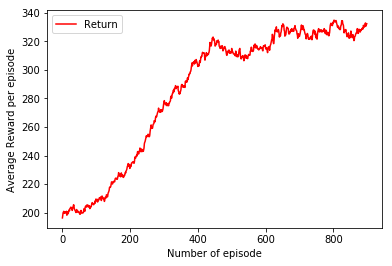

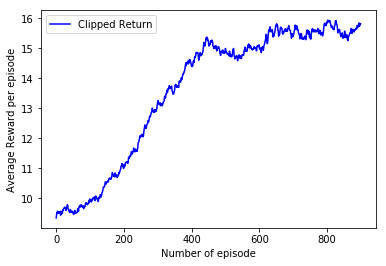

In [13]:
bandwidth = 100


total_clipped = np.zeros(int(epis_count)-bandwidth)
total_rew = np.zeros(int(epis_count)-bandwidth)
for i in range(int(epis_count)-bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i+bandwidth])/bandwidth
    total_rew[i] = np.sum(tot_reward[i:i+bandwidth])/bandwidth
t = np.arange(int(epis_count)-bandwidth)
#likplt = plt.plot(t,total_clipped[0:opt.num_episode-bandwidth],"b", label = "Clipped Return")
belplt = plt.plot(t,total_rew[0:int(epis_count)-bandwidth],"r", label = "Return")
plt.legend()#handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
likplt = plt.plot(t,total_clipped[0:opt.num_episode-bandwidth],"b", label = "Clipped Return")
plt.legend()#handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()

In [ ]:
bandwidth = 100


total_clipped = np.zeros(int(epis_count)-bandwidth)
total_rew = np.zeros(int(epis_count)-bandwidth)
for i in range(int(epis_count)-bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i+bandwidth])/bandwidth
    total_rew[i] = np.sum(tot_reward[i:i+bandwidth])/bandwidth
t = np.arange(int(epis_count)-bandwidth)
#likplt = plt.plot(t,total_clipped[0:opt.num_episode-bandwidth],"b", label = "Clipped Return")
belplt = plt.plot(t,total_rew[0:int(epis_count)-bandwidth],"r", label = "Return")
plt.legend()#handles[likplt,belplt])
plt.xlabel("Number of Samples")
plt.ylabel("Likelihood Ratio and Bellman Error")
plt.show()